In [47]:
#this code is based on the example provided in the xeofs documantation:
#https://xeofs.readthedocs.io/en/latest/content/user_guide/quickstart.html

#as well as the example provided here:
#https://github.com/ajdawson/eofs/blob/main/examples/xarray/sst_example.py

#as well as the example provided here:
#https://projectpythia.org/eofs-cookbook/notebooks/climate-modes-xeofs.html

#https://cdat.llnl.gov/Jupyter-notebooks/scientific/Detrend_Data/Detrend_Data.html

In [48]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xeofs as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import nbconvert

In [49]:
#assuming your slp or sst data is in netCDF file format
data_url = '/Users/zacharytourville/Downloads/msl_60_90N_1981_2019.nc'

#xarray data array of mean sea level pressure as a function of valid_time, latitude, longitude
msl = xr.open_dataset(data_url).msl

In [50]:
msl.shape #468 months, 121 lat, 1440 long

(468, 121, 1440)

In [51]:
#selecting months 6,7,8 (June July August) for summer data
#selecting months 12, 1, 2 (december January, february) for winter data
#we have to account for th efact the a winter season contains the december from the previous year
#when grouped with january and february

msl_sumr = msl.sel(valid_time=msl['valid_time.month'].isin([6, 7, 8]))
msl_wint = msl.sel(valid_time=msl['valid_time.month'].isin([12, 1, 2]))



In [52]:
msl_sumr.shape

(117, 121, 1440)

In [53]:
msl_wint.shape

(117, 121, 1440)

In [55]:
msl_sumr_months = msl_sumr.groupby('valid_time.year').mean()

In [56]:
msl_sumr_months.shape

(39, 121, 1440)

In [57]:
msl_sumr_months_mean = msl_sumr_months.mean(dim = 'year') #mean value of slp all summer months all years, for each gridpoint

In [58]:
msl_sumr_months_mean.shape


(121, 1440)

In [59]:
msl_sumr_months_ds = msl_sumr_months - msl_sumr_months_mean #de-seasoned summer months (anomalies)


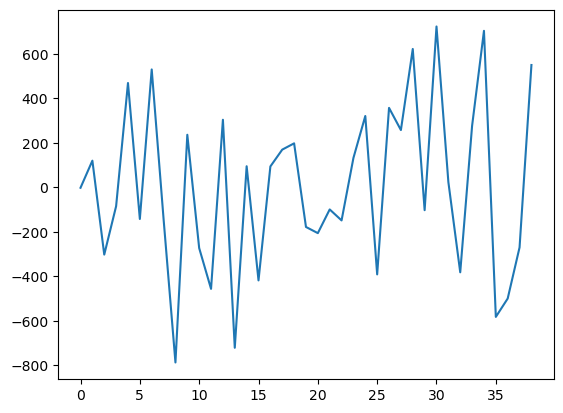

In [60]:
#look at MSL anomalies vs time for one grid box (grid box chosen at random - OK?
plt.plot(msl_sumr_months_ds[:, 2, 2])

In [61]:
"""

def detrend_dim(da, dim, deg=1):
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da.coords[dim], p.polyfit_coefficients)
    return da - fit

msl_sumr_months_dt = detrend_dim(msl_sumr_months, 'year', deg=1)

"""

"\n\ndef detrend_dim(da, dim, deg=1):\n    p = da.polyfit(dim=dim, deg=deg)\n    fit = xr.polyval(da.coords[dim], p.polyfit_coefficients)\n    return da - fit\n\nmsl_sumr_months_dt = detrend_dim(msl_sumr_months, 'year', deg=1)\n\n"

In [62]:
"""

# plot the data and a linear fit - was the de-trend successful?
x = msl_sumr_months_dt.year[:]
y = msl_sumr_months_dt[:, 2, 2]  # Y-axis values

# Calculate the linear regression
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Create the plot
plt.plot(x, y)  # Original data
plt.plot(x, polynomial(x), 'r--', label='Linear trend')  # Regression line
plt.legend()
plt.grid(True)


"""

"\n\n# plot the data and a linear fit - was the de-trend successful?\nx = msl_sumr_months_dt.year[:]\ny = msl_sumr_months_dt[:, 2, 2]  # Y-axis values\n\n# Calculate the linear regression\ncoefficients = np.polyfit(x, y, 1)\npolynomial = np.poly1d(coefficients)\n\n# Create the plot\nplt.plot(x, y)  # Original data\nplt.plot(x, polynomial(x), 'r--', label='Linear trend')  # Regression line\nplt.legend()\nplt.grid(True)\n\n\n"

In [63]:

"""

#Find the trend over time for each grid point:

slope = np.zeros((121, 1440))
intercept = np.zeros((121, 1440))

x = np.arange(39)  # years 0-38
for i in range(121):
    for j in range(1440):
        coeffs = np.polyfit(x, msl_sumr_months_ds.isel(latitude=i, longitude=j).values, 1)
        slope[i,j] = coeffs[0]
        intercept[i,j] = coeffs[1]

# Convert to DataArray if needed
#slope_da = xr.DataArray(slope, dims=['latitude', 'longitude'])

"""

"\n\n#Find the trend over time for each grid point:\n\nslope = np.zeros((121, 1440))\nintercept = np.zeros((121, 1440))\n\nx = np.arange(39)  # years 0-38\nfor i in range(121):\n    for j in range(1440):\n        coeffs = np.polyfit(x, msl_sumr_months_ds.isel(latitude=i, longitude=j).values, 1)\n        slope[i,j] = coeffs[0]\n        intercept[i,j] = coeffs[1]\n\n# Convert to DataArray if needed\n#slope_da = xr.DataArray(slope, dims=['latitude', 'longitude'])\n\n"

In [64]:
"""


fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
cs = ax.contourf(msl_sumr_months_ds.longitude, msl_sumr_months_ds.latitude, 
                 slope, transform=ccrs.PlateCarree(), levels=10)
plt.colorbar(cs)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines()
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())


"""

'\n\n\nfig = plt.figure(figsize=(15,8))\nax = plt.axes(projection=ccrs.NorthPolarStereo())\ncs = ax.contourf(msl_sumr_months_ds.longitude, msl_sumr_months_ds.latitude, \n                 slope, transform=ccrs.PlateCarree(), levels=10)\nplt.colorbar(cs)\nax.add_feature(cfeature.COASTLINE)\nax.gridlines()\nax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())\n\n\n'

In [65]:
"""


#to account for the unequal area of lat/long grids we weight them by the square root of the cosine of the latitude
#this goes to zero as Lat-->90degrees. Some people will only use the cosine (not the square root). Needs further investigation.

def global_average(data):
    weights = np.sqrt(np.cos(np.deg2rad(data.latitude)))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(dim=['latitude', 'longitude'], skipna=True)
#this is taking weighted means over spatial dimensions


"""

"\n\n\n#to account for the unequal area of lat/long grids we weight them by the square root of the cosine of the latitude\n#this goes to zero as Lat-->90degrees. Some people will only use the cosine (not the square root). Needs further investigation.\n\ndef global_average(data):\n    weights = np.sqrt(np.cos(np.deg2rad(data.latitude)))\n    data_weighted = data.weighted(weights)\n    return data_weighted.mean(dim=['latitude', 'longitude'], skipna=True)\n#this is taking weighted means over spatial dimensions\n\n\n"

In [66]:
#summer modes 

sumr_model = xe.single.EOF(n_modes=2, use_coslat=True)
sumr_model.fit(msl_sumr_months_ds, dim='year')
sumr_eofs = sumr_model.components()
sumr_pcs = sumr_model.scores()
sumr_expvar = sumr_model.explained_variance_ratio()

/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


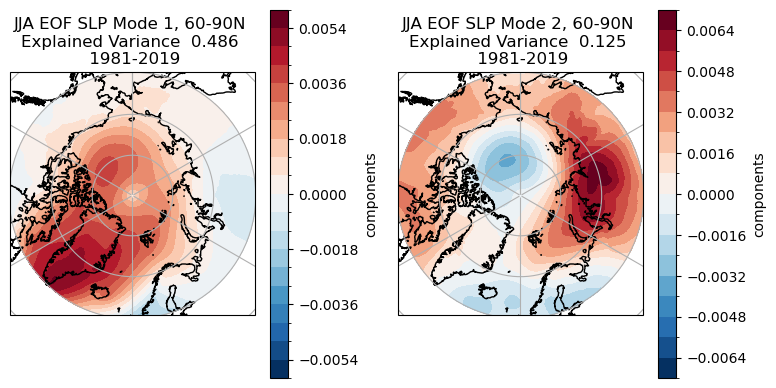

In [67]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
   ax = plt.subplot(1, 4, i+1, projection=ccrs.NorthPolarStereo())
   sumr_eofs.isel(mode=i).plot.contourf(transform=ccrs.PlateCarree(), levels=20, ax=ax)
#sumr_eofs.isel(mode=i).plot(transform=ccrs.PlateCarree(), ax=ax)
   ax.add_feature(cfeature.COASTLINE)
   ax.gridlines()
   ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
   ax.set_title(f"JJA EOF SLP Mode {i+1}, 60-90N \nExplained Variance {sumr_expvar[i].values: .3f} \n 1981-2019")
plt.tight_layout()
plt.show()

In [68]:
JJA_pcs_1 = sumr_pcs[0].to_dataframe().to_csv('/Users/zacharytourville/Downloads/jja_pcs_1_AO.csv')
JJA_pcs_2 = sumr_pcs[1].to_dataframe().to_csv('/Users/zacharytourville/Downloads/jja_pcs_2_AD.csv')

Text(0.5, 1.0, 'Summer AO (PC2) not normalized')

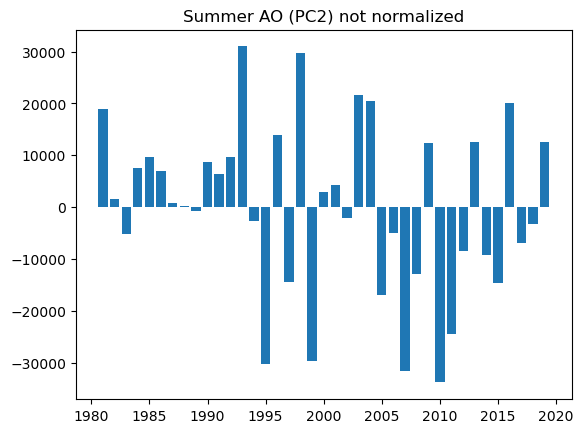

In [151]:
#plt.bar(sumr_pcs.year, sumr_pcs.values[0, :], label='PC1')
plt.bar(sumr_pcs.year, sumr_pcs.values[1, :], label='PC2')
plt.title("Summer AO (PC2) not normalized")

In [70]:
sumr_pcs[1]

<xarray.DataArray 'scores' (year: 39)> Size: 312B
array([ 19015.88707815,   1507.01465195,  -5127.71466653,   7553.05540419,
         9602.63956736,   6920.44755565,    828.44856193,    249.09482814,
         -660.44058756,   8647.71991564,   6432.585569  ,   9733.29663238,
        30996.48450923,  -2724.61259293, -30178.09163873,  13945.98136916,
       -14413.54046234,  29696.2230557 , -29658.67143634,   2866.50036492,
         4251.30862144,  -2001.12883169,  21607.86220299,  20545.54873867,
       -16998.89893547,  -4928.90580025, -31710.20579667, -12945.56961853,
        12452.0012129 , -33830.98085832, -24425.5734398 ,  -8542.84639861,
        12511.67186937,  -9288.28015069, -14550.66728807,  20179.92713923,
        -6918.80978878,  -3225.30576916,  12586.54519976])
Coordinates:
    number   int64 8B 0
  * year     (year) int64 312B 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019
    mode     int64 8B 2
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-02-22 09:00:01
    n_modes:        2
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [71]:
print(sumr_pcs.values.shape)
print(sumr_pcs.year.shape)

(2, 39)
(39,)


## AND NOW FIGURE OUT THE WINTER STUFF

In [183]:
msl_wint.shape

(117, 121, 1440)

In [184]:
msl_wint['season_year'] = msl_wint['valid_time.year']
msl_wint['season_year'] = xr.where(msl_wint['valid_time.month'] == 12, 
                                  msl_wint['valid_time.year'] + 1, 
                                  msl_wint['valid_time.year'])

In [228]:
df07 = pd.DataFrame({
    'valid_time': msl_wint.valid_time[:20].values,
    'season_year': msl_wint.season_year[:20].values,
    'MSL': msl_wint[:20, 2, 2].values
})
print(df07)


   valid_time  season_year          MSL
0  1981-01-01         1981  100247.8125
1  1981-02-01         1981  101030.6875
2  1981-12-01         1982  102018.2500
3  1982-01-01         1982  101938.0625
4  1982-02-01         1982  101370.1875
5  1982-12-01         1983  101800.3750
6  1983-01-01         1983  101393.1875
7  1983-02-01         1983  101124.6875
8  1983-12-01         1984  101823.3750
9  1984-01-01         1984  101376.5000
10 1984-02-01         1984  101364.8125
11 1984-12-01         1985  101440.7500
12 1985-01-01         1985  102381.8125
13 1985-02-01         1985  102370.5000
14 1985-12-01         1986  103269.6250
15 1986-01-01         1986  102284.0000
16 1986-02-01         1986  101925.8750
17 1986-12-01         1987  101425.7500
18 1987-01-01         1987  101407.6250
19 1987-02-01         1987  102310.0625


In [188]:
msl_wint_season = msl_wint.groupby('season_year').mean()

In [230]:
df08 = pd.DataFrame({
    
    'season_year': msl_wint_season.season_year[:20].values,
    'MSL': msl_wint_season[:20, 2, 2].values
})
print(df08)

    season_year            MSL
0          1981  100639.250000
1          1982  101775.500000
2          1983  101439.414062
3          1984  101521.562500
4          1985  102064.351562
5          1986  102493.164062
6          1987  101714.476562
7          1988  101764.335938
8          1989  100081.750000
9          1990  101140.875000
10         1991  101397.710938
11         1992  100640.789062
12         1993  100747.726562
13         1994  102470.710938
14         1995  101470.414062
15         1996  101107.812500
16         1997  101486.062500
17         1998  101866.835938
18         1999  101522.375000
19         2000  101396.375000


In [189]:
msl_wint_mean = msl_wint_season.mean(dim = 'season_year')

In [236]:
msl_wint_ds = msl_wint_season - msl_wint_mean

In [237]:
#msl_wint_mean

In [238]:
df03 = pd.DataFrame({
    'valid_time': msl_wint.valid_time[:20].values,
    'season_year': msl_wint.season_year[:20].values,
    'MSL': msl_wint[:20, 2, 2].values
})
print(df03)

   valid_time  season_year          MSL
0  1981-01-01         1981  100247.8125
1  1981-02-01         1981  101030.6875
2  1981-12-01         1982  102018.2500
3  1982-01-01         1982  101938.0625
4  1982-02-01         1982  101370.1875
5  1982-12-01         1983  101800.3750
6  1983-01-01         1983  101393.1875
7  1983-02-01         1983  101124.6875
8  1983-12-01         1984  101823.3750
9  1984-01-01         1984  101376.5000
10 1984-02-01         1984  101364.8125
11 1984-12-01         1985  101440.7500
12 1985-01-01         1985  102381.8125
13 1985-02-01         1985  102370.5000
14 1985-12-01         1986  103269.6250
15 1986-01-01         1986  102284.0000
16 1986-02-01         1986  101925.8750
17 1986-12-01         1987  101425.7500
18 1987-01-01         1987  101407.6250
19 1987-02-01         1987  102310.0625


In [239]:
df05 = pd.DataFrame({
    'season_year': msl_wint_season.season_year[:20].values,
    'MSL_wint_mean': msl_wint_season[:20, 2, 2].values,
    'season_year_ds': msl_wint_ds.season_year[:20].values,
    'MSL_season_anomaly': msl_wint_ds[:20, 2, 2].values,
    'mean_all_years' : msl_wint_mean[2, 2].values
})
print(df05)

    season_year  MSL_wint_mean  season_year_ds  MSL_season_anomaly  \
0          1981  100639.250000            1981         -849.109375   
1          1982  101775.500000            1982          287.140625   
2          1983  101439.414062            1983          -48.945312   
3          1984  101521.562500            1984           33.203125   
4          1985  102064.351562            1985          575.992188   
5          1986  102493.164062            1986         1004.804688   
6          1987  101714.476562            1987          226.117188   
7          1988  101764.335938            1988          275.976562   
8          1989  100081.750000            1989        -1406.609375   
9          1990  101140.875000            1990         -347.484375   
10         1991  101397.710938            1991          -90.648438   
11         1992  100640.789062            1992         -847.570312   
12         1993  100747.726562            1993         -740.632812   
13         1994  102

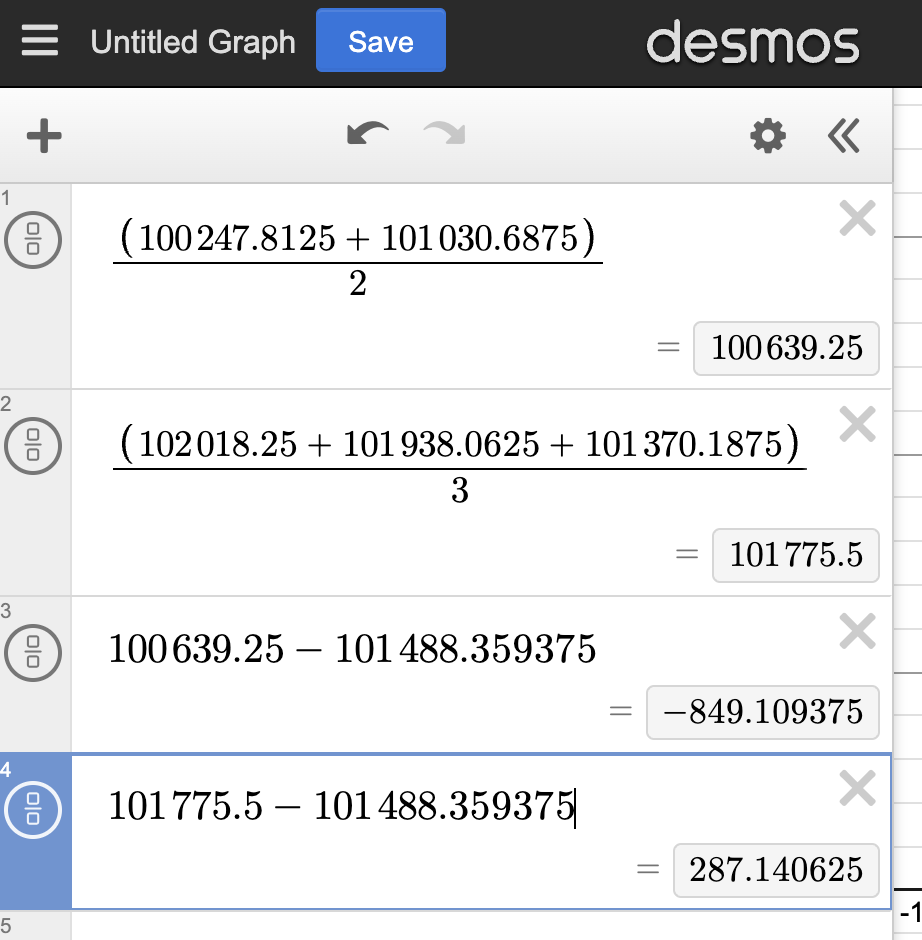

In [152]:
#plt.plot(msl_wint_ds[:, 2,2])

In [118]:
#print(msl_wint_ds)

In [119]:
#msl_wint_season[:, 2, 2] #it worked! these averages have been verified

In [120]:
"""

# plot the data and a linear fit - do we need to de-trend?
x = msl_wint_season.season_year[:]
y = msl_wint_season[:, 2, 2]  # Y-axis values

# Calculate the linear regression
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Create the plot
plt.plot(x, y)  # Original data
plt.plot(x, polynomial(x), 'r--', label='Linear trend')  # Regression line
plt.legend()
plt.grid(True)

"""

"\n\n# plot the data and a linear fit - do we need to de-trend?\nx = msl_wint_season.season_year[:]\ny = msl_wint_season[:, 2, 2]  # Y-axis values\n\n# Calculate the linear regression\ncoefficients = np.polyfit(x, y, 1)\npolynomial = np.poly1d(coefficients)\n\n# Create the plot\nplt.plot(x, y)  # Original data\nplt.plot(x, polynomial(x), 'r--', label='Linear trend')  # Regression line\nplt.legend()\nplt.grid(True)\n\n"

In [88]:
"""

def detrend_dim(da, dim, deg=1):
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da.coords[dim], p.polyfit_coefficients)
    return da - fit

msl_wint_season_dt = detrend_dim(msl_wint_season, 'season_year', deg=1)

"""

In [121]:
"""

# plot the data and a linear fit - was the de-trend successful?
x = msl_wint_season_dt.season_year[:]
y = msl_wint_season_dt[:, 2, 2]  # Y-axis values

# Calculate the linear regression
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Create the plot
plt.plot(x, y)  # Original data
plt.plot(x, polynomial(x), 'r--', label='Linear trend')  # Regression line
plt.legend()
plt.grid(True)

"""

"\n\n# plot the data and a linear fit - was the de-trend successful?\nx = msl_wint_season_dt.season_year[:]\ny = msl_wint_season_dt[:, 2, 2]  # Y-axis values\n\n# Calculate the linear regression\ncoefficients = np.polyfit(x, y, 1)\npolynomial = np.poly1d(coefficients)\n\n# Create the plot\nplt.plot(x, y)  # Original data\nplt.plot(x, polynomial(x), 'r--', label='Linear trend')  # Regression line\nplt.legend()\nplt.grid(True)\n\n"

In [240]:
#winter modes 

wint_model = xe.single.EOF(n_modes=2, use_coslat=True)
wint_model.fit(msl_wint_ds, dim='season_year')
wint_eofs = wint_model.components()
wint_pcs = wint_model.scores()
wint_expvar = wint_model.explained_variance_ratio()

In [241]:
wint_eofs.shape

(2, 121, 1440)

In [242]:
wint_pcs.shape

(2, 40)

/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


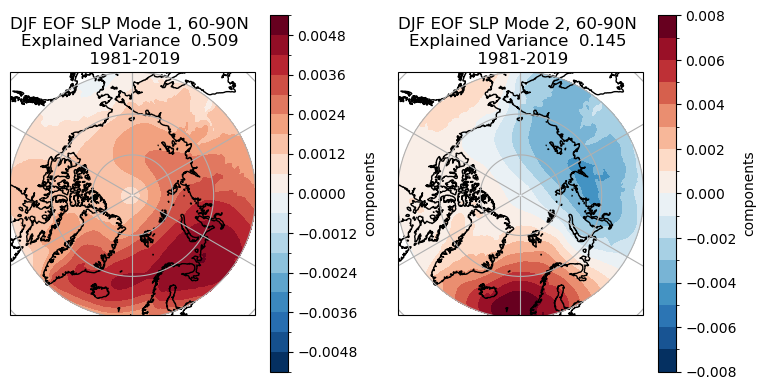

In [243]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
   ax = plt.subplot(1, 4, i+1, projection=ccrs.NorthPolarStereo())
   wint_eofs.isel(mode=i).plot.contourf(transform=ccrs.PlateCarree(), levels=20, ax=ax)
#wint_eofs.isel(mode=i).plot(transform=ccrs.PlateCarree(), ax=ax)
   ax.add_feature(cfeature.COASTLINE)
   ax.gridlines()
   ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
   ax.set_title(f"DJF EOF SLP Mode {i+1}, 60-90N \nExplained Variance {wint_expvar[i].values: .3f} \n 1981-2019")
plt.tight_layout()
plt.show()

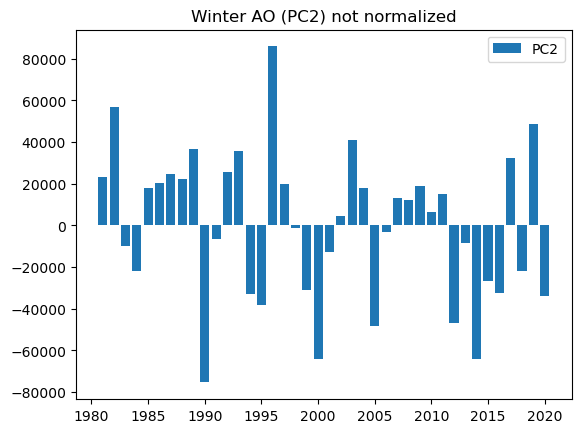

In [150]:
#plt.bar(sumr_pcs.year, sumr_pcs.values[0, :], label='PC1')
plt.bar(wint_pcs.season_year, wint_pcs.values[1, :], label='PC2')
plt.title("Winter AO (PC2) not normalized")
plt.legend()

## check december shift winter EOFs by using just january and february

In [244]:
msl_wint_jf = msl.sel(valid_time=msl['valid_time.month'].isin([1, 2]))

In [245]:
msl_wint_jf

<xarray.DataArray 'msl' (valid_time: 78, latitude: 121, longitude: 1440)> Size: 54MB
[13590720 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 624B 1981-01-01 ... 2019-02-01
  * latitude    (latitude) float64 968B 90.0 89.75 89.5 ... 60.5 60.25 60.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver      (valid_time) <U4 1kB ...
Attributes: (12/32)
    GRIB_paramId:                             151
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      174240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               Pa
    long_name:                                Mean sea level pressure
    units:                                    Pa
    standard_name:                            air_pressure_at_mean_sea_level
    GRIB_surface:                             0.0

In [246]:
msl_wint_jf.shape

(78, 121, 1440)

In [247]:
msl_wint_jf_months = msl_wint_jf.groupby('valid_time.year').mean()

In [248]:
msl_wint_jf_months.shape

(39, 121, 1440)

In [249]:
msl_wint_jf_mean = msl_wint_jf_months.mean(dim = "year")

In [250]:
msl_wint_jf_mean.shape

(121, 1440)

In [251]:
msl_wint_jf_anomalies = msl_wint_jf_months - msl_wint_jf_mean

In [252]:
#msl_wint_jf_anomalies

In [253]:
#winter modes (j, f, not december)

wint_jf_model = xe.single.EOF(n_modes=2, use_coslat=True)
wint_jf_model.fit(msl_wint_jf_anomalies, dim='year')
wint_jf_eofs = wint_jf_model.components()
wint_jf_pcs = wint_jf_model.scores()
wint_jf_expvar = wint_jf_model.explained_variance_ratio()

/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/xeofs_env/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


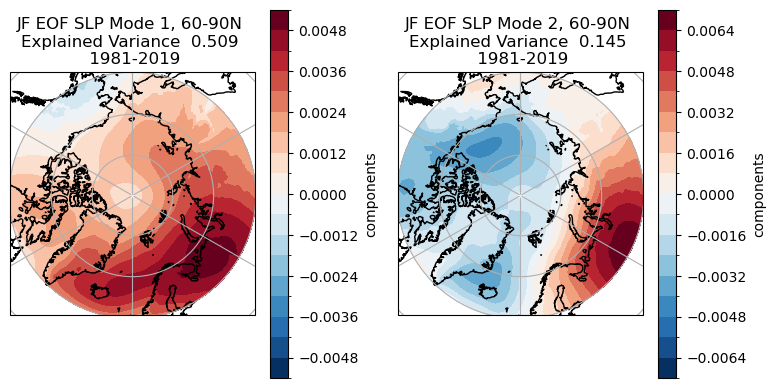

In [254]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
   ax = plt.subplot(1, 4, i+1, projection=ccrs.NorthPolarStereo())
   wint_jf_eofs.isel(mode=i).plot.contourf(transform=ccrs.PlateCarree(), levels=20, ax=ax)
#wint_eofs.isel(mode=i).plot(transform=ccrs.PlateCarree(), ax=ax)
   ax.add_feature(cfeature.COASTLINE)
   ax.gridlines()
   ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
   ax.set_title(f"JF EOF SLP Mode {i+1}, 60-90N \nExplained Variance {wint_expvar[i].values: .3f} \n 1981-2019")
plt.tight_layout()
plt.show()

## IF detrending, code below may be helpful

In [94]:
#de-season the data before de-trending

#to find the anomalies for June (for example), we average the msl for all the Junes (climatology),
#then subtract that value from the msl value for each June
sumr_climatology = msl_sumr.groupby('valid_time.month').mean()
sumr_anomalies = msl_sumr.groupby('valid_time.month') - sumr_climatology

wint_climatology = msl_wint.groupby('valid_time.month').mean()
wint_anomalies = msl_wint.groupby('valid_time.month') - wint_climatology

#maybe should be calculating average for each winter and summer, then de_season and de-trend?
#code for finding winter and summer anomalies, instead of monthly (for winter and summer) below:

In [95]:
sumr_climatology.shape

(3, 121, 1440)

In [96]:
sumr_anomalies.shape

(117, 121, 1440)

In [97]:
sumr_yearly_anomalies = sumr_anomalies.groupby('valid_time.year').mean()

In [98]:
sumr_yearly_anomalies.shape

(39, 121, 1440)

In [99]:
print(sumr_yearly_anomalies['valid_time.year' == 1983])

<xarray.DataArray 'msl' (latitude: 121, longitude: 1440)> Size: 697kB
array([[ 13.3880205,  13.3880205,  13.3880205, ...,  13.3880205,
         13.3880205,  13.3880205],
       [  5.8203125,   5.8020835,   5.7734375, ...,   5.9296875,
          5.908854 ,   5.890625 ],
       [ -1.6692709,  -1.7473959,  -1.7526041, ...,  -1.4895834,
         -1.5625   ,  -1.6197916],
       ...,
       [-25.867188 , -27.213541 , -28.539062 , ..., -21.963541 ,
        -23.309896 , -24.609375 ],
       [-18.822916 , -20.213541 , -21.627604 , ..., -14.7421875,
        -16.054688 , -17.460938 ],
       [-11.671875 , -13.088542 , -14.5286455, ...,  -7.3072915,
         -8.7838545, -10.2161455]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 968B 90.0 89.75 89.5 89.25 ... 60.5 60.25 60.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    year       int64 8B 1981
Attributes: (12/32)
    GRIB_paramId:                             151
    GRIB_dataType:              

In [100]:
#wint_anomalies_mean - modify this code 
# For winter (DJF), we'll assign December to the next year's winter
wint_anomalies['season_year'] = wint_anomalies['valid_time.year']
if wint_anomalies.valid_time.month == 12:
    msl_wint['season_year'] == msl_wint['valid_time.year'] + 1

# Calculate winter averages (DJF)
#winter_df = df[df['month'].isin([12, 1, 2])].copy()
#winter_means = winter_df.groupby('season_year')['ao_index_2'].mean()



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
#sumr_climatology.shape

In [ ]:
#sumr_anomalies.shape

In [ ]:
#to account for the unequal area of lat/long grids we weight them by the square root of the cosine of the latitude
#this goes to zero as Lat-->90degrees. Some people will only use the cosine (not the square root). Needs further investigation.

def global_average(data):
    weights = np.sqrt(np.cos(np.deg2rad(data.latitude)))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(dim=['latitude', 'longitude'], skipna=True)
#this is taking weighted means over spatial dimensions

In [ ]:
#to "detrend" the data (this is important with sst data, but 
#does it even matter for slp? Solving both ways prodeces different results so i guess "yes"
#this cell is not finding the mean over time, but only over space.(?)
#an individual value for each time step

#squeeze gets rid of the single dimension in the data matrix. Is that time in this case? still don't understand squueze.
sumr_anomalies_detrended = (sumr_anomalies - global_average(msl_sumr)).squeeze()
wint_anomalies_detrended = (wint_anomalies - global_average(msl_wint)).squeeze()
#for each month and each gridpoint, this subtracts the spatial average for that month from each value (month, grid point)
#do we instead need the time average for each gridpoint?

In [ ]:
#global_average(msl_sumr).shape
#no longer has latitude and longitude info.
#this is the average pressure over all lat/long for each value of time
#don't we need to use these values to find the trend, from which to subtract pressure values?

In [ ]:
#plt.plot(global_average(msl_sumr))

In [ ]:
#sumr_mean_msl = (global_average(msl_sumr)).mean()
#wint_mean_msl = (global_average(msl_wint)).mean()
#this finds one mean value for msl over both space and time
#I think the detrended anomalies should be calculated using this, rather than global_vaerage(msl_wint)

In [ ]:
#either use this cell or the one below it
#sumr_anomalies_mean_detrended = (sumr_anomalies_mean - sumr_mean_msl).squeeze()

In [ ]:
#to "detrend" the data (this is important with sst data, but 
#does it even matter for slp? Solving both ways prodeces different results so i guess "yes"

#squeeze gets rid of the single dimension in the data matrix. Is that time in this case?
#sumr_anomalies_detrended = (sumr_anomalies - sumr_mean_msl).squeeze()
#wint_anomalies_detrended = (wint_anomalies - wint_mean_msl).squeeze()


In [ ]:
#sumr_anomalies_mean_detrended.shape

In [ ]:
#sumr_anomalies.squeeze().shape
#what is squeeze doing here?

In [ ]:
#sumr_anomalies_detrended.shape

In [ ]:
#sumr_anomalies_detrended.valid_time

In [ ]:
#try the winter season WITH detrending
wint_ds_model_dt = xe.single.EOF(n_modes=2, use_coslat=False)
wint_ds_model_dt.fit(wint_anomalies_detrended, dim='valid_time')
wint_ds_eofs_dt = wint_ds_model_dt.components() #EOFs (spatial patterns)
wint_ds_pcs_dt = wint_ds_model_dt.scores() #PCs (temporal patterns)
wint_ds_expvar_dt = wint_ds_model_dt.explained_variance_ratio()

In [ ]:
wint_ds_pcs_dt.shape

In [ ]:
DJF_pcs_1 = wint_ds_pcs_dt[0].to_dataframe().to_csv('/Users/zacharytourville/Downloads/djf_pcs_1_AO.csv')
DJF_pcs_2 = wint_ds_pcs_dt[1].to_dataframe().to_csv('/Users/zacharytourville/Downloads/djf_pcs_2_AD.csv')

In [ ]:
print(wint_ds_expvar_dt)

In [ ]:
#try plotting the winter modes WITH detrending
fig = plt.figure(figsize=(15, 4))
for i in range(2):
   ax = plt.subplot(1, 2, i+1, projection=ccrs.NorthPolarStereo())
   wint_ds_eofs_dt.isel(mode=i).plot.contour(transform=ccrs.PlateCarree(), levels=10, ax=ax)
   wint_ds_eofs_dt.isel(mode=i).plot(transform=ccrs.PlateCarree(), ax=ax)
   ax.add_feature(cfeature.COASTLINE)
   ax.gridlines()
   ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
   ax.set_title(f"DJF EOF SLP Mode {i+1}, 60-90N \nExplained Variance {wint_ds_expvar_dt[i].values: .3f} \n 1981-2019")
plt.tight_layout()
plt.show()

In [ ]:
#summer modes with detrending

sumr_ds_model_dt = xe.single.EOF(n_modes=2, use_coslat=False)
sumr_ds_model_dt.fit(sumr_anomalies_detrended, dim='valid_time')
sumr_ds_eofs_dt = sumr_ds_model_dt.components()
sumr_ds_pcs_dt = sumr_ds_model_dt.scores()
sumr_ds_expvar_dt = sumr_ds_model_dt.explained_variance_ratio()

In [ ]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
   ax = plt.subplot(1, 2, i+1, projection=ccrs.NorthPolarStereo())
   sumr_ds_eofs_dt.isel(mode=i).plot.contour(transform=ccrs.PlateCarree(), levels=10, ax=ax)
   sumr_ds_eofs_dt.isel(mode=i).plot(transform=ccrs.PlateCarree(), ax=ax)
   ax.add_feature(cfeature.COASTLINE)
   ax.gridlines()
   ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
   ax.set_title(f"JJA EOF SLP Mode {i+1}, 60-90N\nExplained Variance {sumr_ds_expvar_dt[i].values:.3f} \n1981-2019")
plt.tight_layout()
plt.show()

In [ ]:
JJA_pcs_1 = wint_ds_pcs_dt[0].to_dataframe().to_csv('/Users/zacharytourville/Downloads/jja_pcs_1_AO.csv')
JJA_pcs_2 = wint_ds_pcs_dt[1].to_dataframe().to_csv('/Users/zacharytourville/Downloads/jja_pcs_2_AD.csv')

print(sumr_ds_expvar_dt[0].values)

sumr_mean_ds_model = xe.single.EOF(n_modes=2, use_coslat=True)
sumr_mean_ds_model.fit(sumr_anomalies_mean_detrended, dim='year')
sumr_mean_ds_eofs = sumr_mean_ds_model.components()
sumr_mean_ds_pcs = sumr_mean_ds_model.scores()
sumr_mean_ds_expvar = sumr_mean_ds_model.explained_variance_ratio()

In [ ]:
print(sumr_mean_ds_expvar)

In [ ]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
   ax = plt.subplot(1, 4, i+1, projection=ccrs.NorthPolarStereo())
   sumr_mean_ds_eofs.isel(mode=i).plot.contour(transform=ccrs.PlateCarree(), levels=10, ax=ax)
   sumr_mean_ds_eofs.isel(mode=i).plot(transform=ccrs.PlateCarree(), ax=ax)
   ax.add_feature(cfeature.COASTLINE)
   ax.gridlines()
   ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
   #ax.title="JJA EOF SLP"
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
   ax = plt.subplot(1, 4, i+1, projection=ccrs.NorthPolarStereo())
   sumr_ds_eofs.isel(mode=i).plot.contour(transform=ccrs.PlateCarree(), levels=10, ax=ax)
   sumr_ds_eofs.isel(mode=i).plot(transform=ccrs.PlateCarree(), ax=ax)
   ax.add_feature(cfeature.COASTLINE)
   ax.gridlines()
   ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
   #ax.title="JJA EOF SLP"
plt.tight_layout()
plt.show()

In [ ]:
sumr_ds_eofs.plot()
